<a href="https://colab.research.google.com/github/BrianLegacy/Automaopmatic-Number-Plate-Recognition/blob/main/Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 5 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 3s (1,594 kB/s)
debconf: unable to initia

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
path = glob('/content/drive/MyDrive/Data1/images/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [ ]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,/content/drive/MyDrive/Data1/images/N107.xml,207,356,174,287
1,/content/drive/MyDrive/Data1/images/N164.xml,248,421,121,174
2,/content/drive/MyDrive/Data1/images/N175.xml,183,250,205,229
3,/content/drive/MyDrive/Data1/images/N154.xml,106,245,157,196
4,/content/drive/MyDrive/Data1/images/N122.xml,342,494,243,288


In [ ]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('/content/drive/MyDrive/Data1/images',filename_image)
    return filepath_image
getFilename(filename)

'/content/drive/MyDrive/Data1/images/N107.jpeg'

In [ ]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random chec

['/content/drive/MyDrive/Data1/images/N107.jpeg',
 '/content/drive/MyDrive/Data1/images/N164.jpeg',
 '/content/drive/MyDrive/Data1/images/N175.jpeg',
 '/content/drive/MyDrive/Data1/images/N154.jpeg',
 '/content/drive/MyDrive/Data1/images/N122.jpeg',
 '/content/drive/MyDrive/Data1/images/N172.jpeg',
 '/content/drive/MyDrive/Data1/images/N16.jpeg',
 '/content/drive/MyDrive/Data1/images/N102.jpeg',
 '/content/drive/MyDrive/Data1/images/N110.jpeg',
 '/content/drive/MyDrive/Data1/images/N1.jpeg']


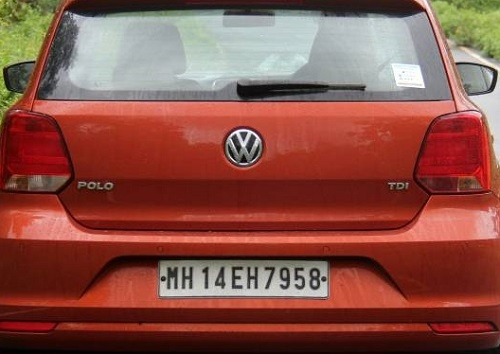

In [ ]:
file_path = image_path[87] #path of our image N2.jpeg
img = cv2.imread(file_path) #read the image
# xmin-1804/ymin-1734/xmax-2493/ymax-1882 
img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 8 - N2.jpeg with bounding box')
fig.add_shape(type='rect',x0=1804, x1=2493, y0=1734, y1=1882, xref='x', yref='y',line_color='cyan')

In [ ]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [ ]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [ ]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

In [ ]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

219055592/219055592 [==============================] - 10s 0us/step


In [ ]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=180,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/180
18/18 [==============================] - 38s 480ms/step - loss: 0.0406 - val_loss: 0.0396
Epoch 2/180
18/18 [==============================] - 4s 250ms/step - loss: 0.0158 - val_loss: 0.0178
Epoch 3/180
18/18 [==============================] - 4s 252ms/step - loss: 0.0098 - val_loss: 0.0154
Epoch 4/180
18/18 [==============================] - 4s 251ms/step - loss: 0.0060 - val_loss: 0.0117
Epoch 5/180
18/18 [==============================] - 4s 235ms/step - loss: 0.0039 - val_loss: 0.0113
Epoch 6/180
18/18 [==============================] - 5s 254ms/step - loss: 0.0034 - val_loss: 0.0114
Epoch 7/180
18/18 [==============================] - 6s 330ms/step - loss: 0.0034 - val_loss: 0.0097
Epoch 8/180
18/18 [==============================] - 4s 239ms/step - loss: 0.0026 - val_loss: 0.0083
Epoch 9/180
18/18 [==============================] - 4s 240ms/step - loss: 0.0026 - val_loss: 0.0113
Epoch 10/180
18/18 [==============================] - 4s 241ms/step - loss: 0.0031 - val_l

In [ ]:
model.save('./object_detection.h5')

In [ ]:
# Load model
model = tf.keras.models.load_model('./object_detection.h5')
print('Model loaded Sucessfully')

Model loaded Sucessfully


In [ ]:
path = '/content/drive/MyDrive/Data1/TEST/TEST.jpeg'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)

Height of the image = 729
Width of the image = 901



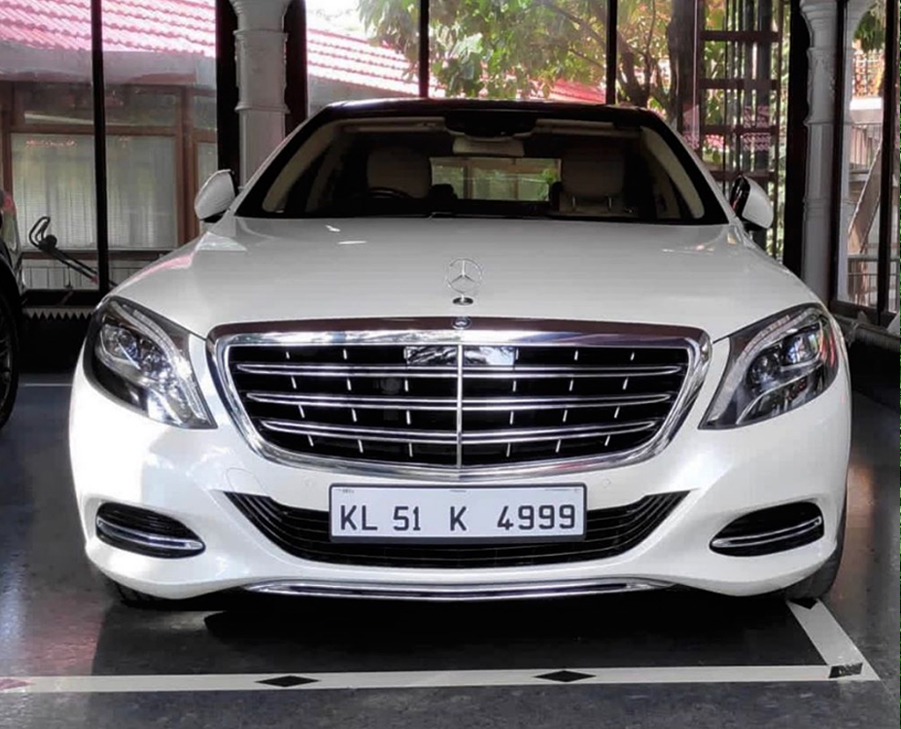

In [ ]:
fig = px.imshow(image)
fig.update_layout(width=700, height=500,  margin=dict(l=10, r=10, b=10, t=10), xaxis_title='Figure 13 - TEST Image')

In [ ]:
image_arr_224.shape

(224, 224, 3)

In [ ]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

In [ ]:
# Make predictions
coords = model.predict(test_arr)
coords

1/1 [==============================] - 4s 4s/step


array([[0.3710275 , 0.6377149 , 0.6275606 , 0.72083384]], dtype=float32)

In [ ]:
# Denormalize the values
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[334.29577699, 574.58114511, 457.49168873, 525.48786789]])

In [ ]:
coords = coords.astype(np.int32)
coords

array([[334, 574, 457, 525]], dtype=int32)

In [ ]:
# Draw bounding on top the image
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(334, 457) (574, 525)



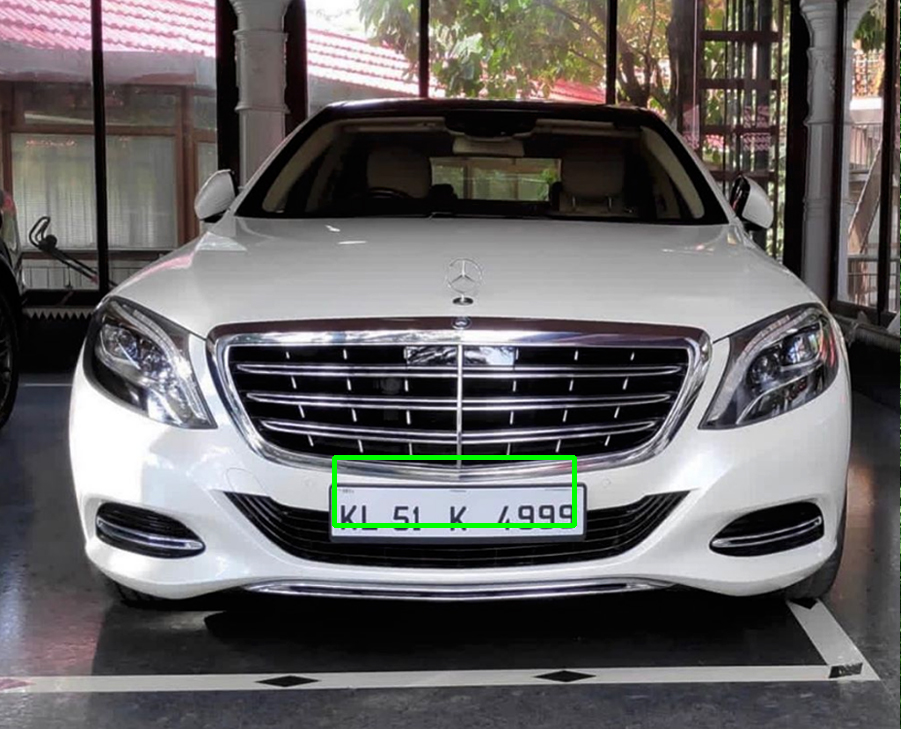

In [ ]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))

1/1 [==============================] - 0s 39ms/step
(55, 49) (242, 92)



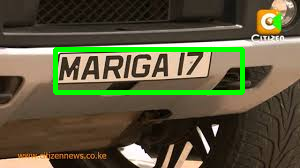

In [ ]:
# Create pipeline
path = '/content/drive/MyDrive/Data1/TEST/test2.jpg'
def object_detection(path):
    
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    coords = model.predict(test_arr)
    
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')


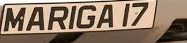

In [ ]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 15 Cropped image')

In [ ]:
# extract text from image
text = pt.image_to_string(roi)
print(text)

MARIGA I7|

